In [32]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import pickle, gzip, urllib.request, json
from IPython.core.debugger import Pdb # we encourage you to use the degubber, rather than print statements

In [33]:
#To ensure reproducibility
random.seed(11)
np.random.seed(11)

In [34]:
# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

# Get the data into arrays
train_images = train_set[0].transpose()
train_labels = train_set[1].transpose()

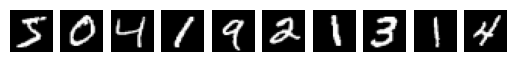

In [35]:
#Plot some example images to make sure everything is loaded in properly
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(train_images[:,c].reshape((28,28)), cmap='gray')
    axs[c].axis("off")
plt.show()

In [43]:
##############################################################################################
# Some helper functions

# The sigmoid function
def sigmoid(X):
    """
    Returns the sigmoid function, i.e. 1/(1+exp(-X))
    """
    
    # to avoid runtime warnings, if abs(X) is more than 500, let's just cap it there
    toobig   = X > 500
    toosmall = X < -500
    X[toobig]   = 500
    X[toosmall] = -500
        
    return 1.0/(1.0 + np.exp(-X))
 
# A helper function to add an "always on" bias units to the inputs
def add_bias(inputs):
    """
    Append an "always on" bias to some inputs
    """
    return np.append(inputs,np.ones((1,inputs.shape[1])),axis=0)

# Creates a random set of batches, returns an array of indices, one for each batch
def create_batches(batch_size, num_samples):
    """
    For a given number of samples, returns an array of indices of random batches of the specified size.
    
    If the size of the data is not divisible by the batch size some samples will not be included.
    """
    
    # determine the total number of batches
    num_batches = int(np.floor(num_samples/batch_size))
    
    # get the batches (without replacement)
    return np.random.choice(np.arange(num_samples),size=(num_batches,batch_size),replace=False)

# Calculate the description length cost of the given set of activities given the probabilities
def estimate_cost(rec_activities,gen_probabilities):
    """
    Calculates the mean description length cost (in bits) for the given activities/probabilities 
    (see equation 3 in Hinton 1995). 
    
    - rec_activities is an array of the activity from a recognition pass
    - gen_probabilities is an array of the probabilities of unit activations from a generative pass
    
    Note: these two variables must be the same size
    """
    
    # verify the arguments
    assert np.all(rec_activities.shape == gen_probabilities.shape), "The given arrays must have the same shape"
    
    # add some tiny values to the probabilities to ensure that we are not getting nans from our log
    on_gen_p  = gen_probabilities + 1e-20
    off_gen_p = 1 - gen_probabilities + 1e-20
    
    # calculate the description cost for the generative model for each data sample 
    C_alpha_d = np.sum(-rec_activities*np.log2(on_gen_p) - (1-rec_activities)*(np.log2(off_gen_p)), axis=1)
    
    # return the average cost
    return np.mean(C_alpha_d)

In [44]:
##############################################################################################    
# A generic base class for the layers in a Helmholtz network
class Helmholtz_Layer(object):
    """
    A single layer for a Helmholtz network
    """
    
    # The initialization function for the layer
    def __init__(self,N,M,K,B):
        """
        The initialization function for the base helmholtz_layer class.
        
        Notes: 
         - N is the number of units in the layer
         - M is the number of units in the layer above (should be zero for top layer)
         - K is the number of units in the layer below (should be minus one for input layer)
         - B is the batch size
        """
        self.N = N
        self.probability = np.zeros((N,B)) # the probability that each unit will activate
        self.activity    = np.zeros((N,B)) # the activity itself, 1s or 0s for non-input layers
        self.gen_weights = np.random.normal(size=(N,M+1)) # the generative weights coming into this layer
        self.rec_weights = np.random.normal(size=(N,K+1)) # the recognition weights coming into this layer
    
    # Sample activity based on the probabilities
    def sample(self):
        """
        Samples activity values (0 or 1) based on the current probabilities of activation
        """
        
        # use a uniformly distributed variable to sample the activities from the probabilities
        self.activity = (np.random.uniform(size=self.activity.shape) < self.probability).astype(float)
        
    # Integrate incoming top-down activity to calculate probabilities during generation
    def genintegrate(self,inputs,store=True):
        """
        Integrates incoming top-down activity to calculate probabilities during generation.
        
        If store is True, then the probabilities will be stored in the layer, otherwise they
        will be returned.
        """
        
        # add a bias unit to the incoming generative inputs
        gen_inputs = add_bias(inputs)
        
        # multiply by the weights to get the net input
        netin = np.matmul(self.gen_weights, gen_inputs) 
        
        # calculate the probabilities for the layer based on the net input
        if store:
            self.probability = sigmoid(netin)
        else:
            return sigmoid(netin)
    
    # Integrate incoming bottom-up activity to calculate probabilities during recognition
    def recintegrate(self,inputs,store=True):
        """
        Integrates incoming bottom-up activity to calculate probabilities during recogition.
        
        If store is True, then the probabilities will be stored in the layer, otherwise they
        will be returned.
        """
        
        # add a bias unit to the incoming recognition inputs
        rec_inputs = add_bias(inputs)
        
        # multiply by the weights to get the net input
        netin = np.matmul(self.rec_weights, rec_inputs) 
        
        # calculate the probabilities for the layer based on the net input
        if store:
            self.probability = sigmoid(netin)
        else:
            return sigmoid(netin)

##############################################################################################
# A class for the input layer in a Helmholtz network
class Input_Layer(Helmholtz_Layer):
    """
    An input layer for a Helmholtz network
    """
    
    # The initialization function for the layer
    def __init__(self,N,M,K,B):
        """
        The initialization function for the Input_Layer class.
        
        Notes: 
         - N is the number of units in the layer
         - M is the number of units in the layer above
         - K is the number of units in the layer below (should be -1)
         - B is the batch size
        """
        
        # check that the right K was given
        assert K == -1, "Input layers cannot have inputs from below"
        
        Helmholtz_Layer.__init__(self,N,M,K,B)
    
    # Sets probabilities during recognition
    def recintegrate(self,inputs,store=True):
        """
        Sets the probabilities to be the incoming input.
        
        If store is True, then the probabilities will be stored in the layer, otherwise they
        will be returned.
        """
        
        # set the probabilities to be equal to the input
        if store:
            self.probability = inputs
        else:
            return inputs
    
##############################################################################################        
# A class for the top layer in a Helmholtz network
class Top_Layer(Helmholtz_Layer):
    """
    A top layer for a Helmholtz network
    """
    
    # The initialization function for the layer
    def __init__(self,N,M,K,B):
        """
        The initialization function for the Top_Layer class.
        
        Notes: 
         - N is the number of units in the layer
         - M is the number of units in the layer above (should be 0)
         - K is the number of units in the layer below
         - B is the batch size
        """
        
        # check that we got the right value of M
        assert M == 0, "Top layers cannot have inputs from above"
        
        Helmholtz_Layer.__init__(self,N,M,K,B)
        
    # Integrate incoming top-down activity to calculate probabilities during generation
    def genintegrate(self,inputs,store=True):
        """
        Sets the probabilities based on the biases.
        
        If store is True, then the probabilities will be stored in the layer, otherwise they
        will be returned.
        """
        
        # calculate the probabilities for the layer based on the biases
        if store:
            self.probability = sigmoid(self.gen_weights)
        else:
            return sigmoid(self.gen_weights)
        
##############################################################################################        
# A class for the top layer in a Helmholtz network
class Hidden_Layer(Helmholtz_Layer):
    """
    A hidden layer for a Helmholtz network
    """
    
    # The initialization function for the layer
    def __init__(self,N,M,K,B):
        """
        The initialization function for the Top_Layer class.
        
        Notes: 
         - N is the number of units in the layer
         - M is the number of units in the layer above
         - K is the number of units in the layer below
         - B is the batch size
        """
        Helmholtz_Layer.__init__(self,N,M,K,B)


In [120]:
##############################################################################################
# The main Helmholtz network class
class Helmholtz_Network(object):
    """
    The class for creating and training Helmholtz Networks.
    """
    
    # The initialization function for the helmholtz network
    def __init__(self,N,B,eta):
        """
        The initialization function for Helmholtz Networks.
        
         - N is a list of the number of units in each layer, length of N defines number of layers
         - B is the batch size
         - eta is the learning rate
        """
        
        # verify that we have at least two layers (otherwise it is meaningless)
        assert len(N) >= 2, "A Helmholtz network needs at least two layers"
        
        # initialize each of the layers
        self.layers = []
        for i in range(len(N)):
            
            # make sure we have a positive integer
            assert isinstance(N[i],int) and N[i] > 0, "layer sizes must be positive integers"
            
            # if it is the first layer, create an input layer
            if i == 0:
                self.layers.append(Input_Layer(N[i],N[i+1],-1,B))
            elif i == (len(N)-1): # it is the top layer
                self.layers.append(Top_Layer(N[i],0,N[i-1],B))
            else: # it is a hidden layer
                self.layers.append(Hidden_Layer(N[i],N[i+1],N[i-1],B))
                
        # store the layer sizes, batch size, and learning rate for easy access
        self.N   = N
        self.B   = B
        self.eta = eta
                
    # The function for performing a forward pass up through the network during recognition
    def recognize(self,inputs):
        """
        Recognize inputs, i.e. do a forward pass up through the network
        """
        
        # step through the layers, activating them
        for i in range(len(self.layers)):
            
            # set the incoming activity
            if i == 0:
                incoming = inputs
            else:
                incoming = self.layers[i-1].activity
            
            # integrate the inputs
            self.layers[i].recintegrate(incoming)
            
            # sample the activity
            self.layers[i].sample()
            
    # The function for performing a pass down through the network during generation
    def generate(self):
        """
        Generate inputs, i.e. do a downward pass through the network
        """
        
        # step through the layers, activating them
        for i in range(len(self.layers)-1,-1,-1):
            
            # set the incoming activity
            if i == (len(self.layers)-1):
                incoming = np.zeros(self.layers[i].activity.shape)
            else:
                incoming = self.layers[i+1].activity
            
            # integrate the inputs
            self.layers[i].genintegrate(incoming)
            
            # sample the activity
            self.layers[i].sample()

    # The function for running one training pass in the "wake" phase, updates the generative weights
    def wake(self,inputs,update=True):
        """
        Do one pass through a batch for the wake phase, with the given inputs, and update the generative weights.
        
        If update is False, then the weights are not actually updated.
        """
        
        # do a forward pass through the network
        self.recognize(inputs)
        
        # update the weights in each layer (for the top layer, this will just be the biases)
        layer_count = len(self.layers)
        # Loop backwards through the layers to perform generative updates (top-down)
        for idx in reversed(range(layer_count)):
            gen_layer = self.layers[idx]
    
            if not update:
                continue  # Skip actual updates if we're not in training mode
    
            # Get the activity of the layer above (or use bias-only input for the top layer)
            if idx + 1 < layer_count:
                activations = self.layers[idx + 1].activity
            else:
                activations = np.ones((1, self.B))  # Top layer uses bias only (no higher layer)
    
            # Compute input to generative units based on higher layer activity
            gen_layer.genintegrate(activations)
    
            # Compute prediction error: actual activation - predicted activation (sigmoid probability)
            diff = gen_layer.activity - gen_layer.probability
    
            if idx + 1 < layer_count:
                # Add bias term to upper layer activity before computing gradient
                biased_upper = add_bias(activations)
    
                # Calculate gradient for generative weights (outer product of error and inputs)
                grad = diff @ biased_upper.T
    
                # Update generative weights using learning rate
                gen_layer.gen_weights += self.eta * grad
    # The function for running one training pass in the "sleep" phase, updates the recognition weights
    def sleep(self,update=True):
        """
        Do one pass through a batch for the sleep phase and update the recognition weights.
        
        If update is False, then the weights are not actually updated.
        """
        
        # do a forward pass through the network
        self.generate()
        
        # update the weights in each layer (except the bottom, where there are no weights to update)
        # Loop forward through the layers (bottom-up) to update recognition weights
        for idx in range(1, len(self.layers)):
            # Get the pair of layers involved in this recognition update
            dream_input = self.layers[idx - 1]    # lower layer (input to recognition)
            dream_target = self.layers[idx]       # current layer (target for recognition)
    
            if not update:
                continue  # Skip actual updates if not training
    
            # Compute recognition model’s prediction for latent causes
            dream_target.recintegrate(dream_input.activity)
    
            # Compute error between sampled latent cause and recognition model’s predicted probability
            error = dream_target.activity - dream_target.probability
    
            # Add bias to input layer activity
            lower_with_bias = add_bias(dream_input.activity)
    
            # Compute gradient and update recognition weights
            rec_update = error @ lower_with_bias.T
            dream_target.rec_weights += self.eta * rec_update
        
        
    def wake_sleep_train(self,train_data,num_epochs,report_rate=10,wake_update=True,sleep_update=True):
        """
        Trains the network using the wake-sleep algorithm in batches for the given number of epochs.
        
        Prints a message every report_rate epochs.
        
        If wake_update or sleep_update are set to false then the weights are not 
        actually updated during those phases.
        """
        
        # provide an output message
        print("Training starting...")
        
        # make batches from the data
        batches = create_batches(self.B,train_data.shape[1])
        
        # create some arrays to store activities and probabilities across batches (will be used to estimate loss)
        rec_activities    = np.zeros((np.sum(self.N),train_data.shape[1]))
        rec_probabilities = np.zeros((np.sum(self.N),train_data.shape[1]))
        gen_probabilities = np.zeros((np.sum(self.N),train_data.shape[1]))
        
        # create an array to store cost values
        costs = np.zeros((num_epochs,))
        
        # run the training for the given number of epochs
        for epoch in range(num_epochs):
            
            # step through each batch
            for b in range(batches.shape[0]):
                
                # run a wake phase
                self.wake(train_data[:,batches[b,:]],update=wake_update)
                
                # store stuff for calculating the loss
                counter = 0
                for i in range(len(self.N)):
                    rec_activities[counter:counter+self.N[i],batches[b,:]]   = self.layers[i].activity
                    rec_probabilities[counter:counter+self.N[i],batches[b,:]] = self.layers[i].probability
                    counter += self.N[i]
                
                # run a sleep phase
                self.sleep(update=sleep_update)
                
                # store stuff for calculating the loss
                counter = 0
                for i in range(len(self.N)):
                    gen_probabilities[counter:counter+self.N[i],batches[b,:]] = self.layers[i].probability
                    counter += self.N[i]
                    
            # calculate the cost (estimate it, technically)
            costs[epoch] = estimate_cost(rec_activities,gen_probabilities)
                
            # print an output message every 10 epochs
            if np.mod(epoch+1,report_rate) == 0:
                print("...completed ", epoch+1, 
                      " epochs of training. Current avg cost is: ",round(costs[epoch],2), "bits.")
                
        # provide an output message
        print("Training complete.")
        
        return costs
        
    # Generate some images from the network (for ease, batch size is max number), return them in an array
    def dream(self,number=10):
        """
        Returns some generated images in an array.
        
        Optional argument number determines how many images. This cannot be more than the batch size
        but it can be less than it. Default is 10.
        """
        
        # make sure the requested number works
        if number > self.B:
            number = self.B
        
        # generate some images
        self.generate()
        
        # the "dreams" are the self.layers[0].probability
        dreams = self.layers[0].probability
        
        # determine the size of the plot, put a maximum of 10 images per row
        numrows    = int(np.ceil(number/10))
        numcols    = min(number,10)        
        
        # create the plot
        fig, axs = plt.subplots(numrows,numcols,squeeze=False)
        
        # step through the units and plot their weights
        for i in range(number):
            
            # determine the row and column
            r = int(np.floor(i/10))
            c = int(np.mod(i,10))
            
            # plot the weights
            axs[r,c].imshow(dreams[:,i].reshape(28,28), cmap='gray', interpolation=None)
            axs[r,c].axis("off")
            
        # show the plot
        plt.show()
        
        # return the input layer probabilities (these are the images)
        return dreams
        
    # Plot the generative weights in the network at the specified layer
    def show_gen_weights(self, layer, image_size=(28,28), number=10):
        """
        Create an image of the generative weights in the network at the layer specified (must be an integer).
        
        Note: the layer specifies the layer that the weights *come from*.
        
        Optional argument image_size allows one to determine the shape of the images plotted. 
        Default is the correct size for MNIST images.
        
        Optional argument number is the number of units' weights to plot. Default is 10.
        """
        
        # check that an appropriate integer was provided
        assert isinstance(layer,int) and (layer > 0 and layer < len(self.layers)+1)
        
        # make sure that we're not asking for more units then there are, adjust accordingly
        if number > self.N[layer]:
            number = self.N[layer]
        
        # determine the layer below by one since we organize weights by the layer they go to
        layer_below = layer - 1
        
        # determine the size of the plot, put a maximum of 10 weights per row
        numrows    = int(np.ceil(number/10))
        numcols    = min(number,10)        
        
        # create the plot
        fig, axs = plt.subplots(numrows,numcols,squeeze=False)
        
        # step through the units and plot their weights
        for i in range(number):
            
            # determine the row and column
            r = int(np.floor(i/10))
            c = int(np.mod(i,10))
            
            # plot the weights
            axs[r,c].imshow(self.layers[layer_below].gen_weights[:,i].reshape(image_size), 
                            cmap='gray', interpolation=None)
            axs[r,c].axis("off")
            
        # show the plot
        plt.show()
        
    # Plot the recognition weights in the network at the specified layer
    def show_rec_weights(self, layer, image_size=(28,28), number=10):
        """
        Create an image of the recognition weights in the network at the layer specified (must be an integer).
        
        Note: the layer specifies the layer that the weights *go to*.
        
        Optional argument image_size allows one to determine the shape of the images plotted. 
        Default is the correct size for MNIST images.
        
        Optional argument number is the number of units' weights to plot. Default is 10.
        """
        
        # check that an appropriate integer was provided
        assert isinstance(layer,int) and (layer > 0 and layer < len(self.layers))
                
        # make sure that we're not asking for more units then there are, adjust accordingly
        if number > self.N[layer]:
            number = self.N[layer]
            
        # determine the size of the plot, put a maximum of 10 weights per row
        numrows    = int(np.ceil(number/10))
        numcols    = min(number,10)        
        
        # create the plot
        fig, axs = plt.subplots(numrows,numcols,squeeze=False)
        
        # step through the units and plot their weights
        for i in range(number):
            
            # determine the row and column
            r = int(np.floor(i/10))
            c = int(np.mod(i,10))
            
            # plot the weights
            axs[r,c].imshow(self.layers[layer].rec_weights[i,:-1].reshape(image_size), 
                            cmap='gray', interpolation=None)
            axs[r,c].axis("off")
            
        # show the plot
        plt.show()
            

Training starting...
...completed  2  epochs of training. Current avg cost is:  3002.89 bits.
...completed  4  epochs of training. Current avg cost is:  2642.62 bits.
...completed  6  epochs of training. Current avg cost is:  2547.25 bits.
...completed  8  epochs of training. Current avg cost is:  2555.76 bits.
...completed  10  epochs of training. Current avg cost is:  2584.83 bits.
...completed  12  epochs of training. Current avg cost is:  2607.59 bits.
...completed  14  epochs of training. Current avg cost is:  2633.53 bits.
...completed  16  epochs of training. Current avg cost is:  2678.71 bits.
...completed  18  epochs of training. Current avg cost is:  2730.63 bits.
...completed  20  epochs of training. Current avg cost is:  2743.92 bits.
...completed  22  epochs of training. Current avg cost is:  2767.64 bits.
...completed  24  epochs of training. Current avg cost is:  2781.18 bits.
...completed  26  epochs of training. Current avg cost is:  2796.75 bits.
...completed  28  epo

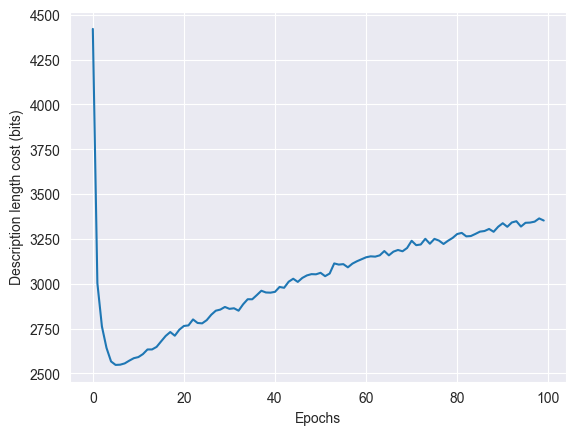

In [105]:
# Create a network and train it on threes and zeros
numtop = 10 # number of top layer units
numhid = 20 # number of hidden layer units
batchsize = 40
learnrate = 0.001
numepochs = 100
hnet = Helmholtz_Network([784,numhid,numtop],batchsize,learnrate)
train_zeros = train_labels == 0
train_threes = train_labels == 3
train_eights = train_labels == 8

############################################################
# below are various statements for training the network with different categories, 
# you can play around with them and modify as you see fit to answer the questions
# in the assignment

# train on just zeros
costs = hnet.wake_sleep_train(train_images[:,train_zeros],numepochs,
                              report_rate=2,wake_update=True,sleep_update=True)

# # train on eights and threes
# costs = hnet.wake_sleep_train(train_images[:,train_eights+train_threes],numepochs,
#                               report_rate=2,wake_update=True,sleep_update=True)

# train on all the 
#costs = hnet.wake_sleep_train(train_images,numepochs,report_rate=2,wake_update=True,sleep_update=True)

# Plot the description length cost over epochs (if working well, should go down at first, then come up a bit)
plt.plot(costs)
plt.xlabel("Epochs")
plt.ylabel("Description length cost (bits)")
plt.show()

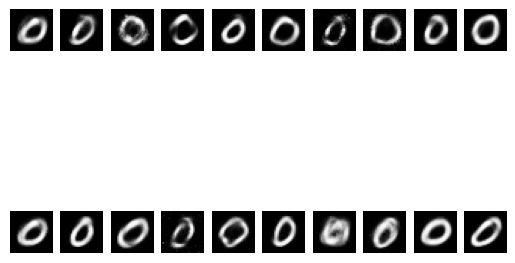

In [106]:
##################################################################################################################
# Generate some images to see what the model's generative component has learned
dreams = hnet.dream(number=20)

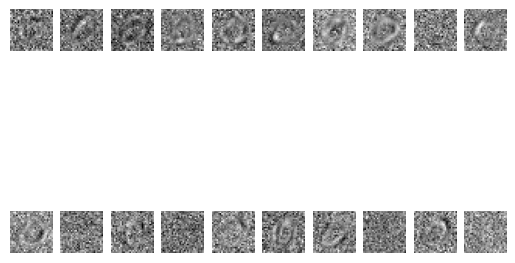

In [107]:
##################################################################################################################
# Examine the recognition weights to see what they look like
hnet.show_rec_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_rec_weights(1,number=numhid) # for the hidden layer

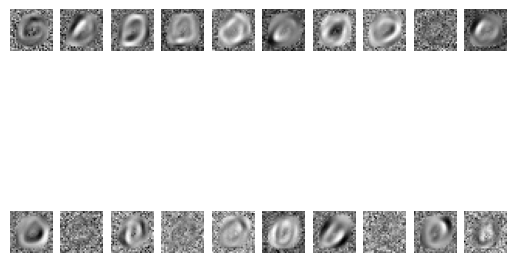

In [108]:
##################################################################################################################
# Examine some of the lowest level generative weights to see what they look like
hnet.show_gen_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_gen_weights(1,number=numhid) # for the hidden layer

Training starting...
...completed  2  epochs of training. Current avg cost is:  5195.18 bits.
...completed  4  epochs of training. Current avg cost is:  4687.21 bits.
...completed  6  epochs of training. Current avg cost is:  4698.05 bits.
...completed  8  epochs of training. Current avg cost is:  4835.97 bits.
...completed  10  epochs of training. Current avg cost is:  4910.81 bits.
...completed  12  epochs of training. Current avg cost is:  5038.8 bits.
...completed  14  epochs of training. Current avg cost is:  5076.55 bits.
...completed  16  epochs of training. Current avg cost is:  5165.49 bits.
...completed  18  epochs of training. Current avg cost is:  5246.34 bits.
...completed  20  epochs of training. Current avg cost is:  5329.53 bits.
...completed  22  epochs of training. Current avg cost is:  5382.59 bits.
...completed  24  epochs of training. Current avg cost is:  5455.67 bits.
...completed  26  epochs of training. Current avg cost is:  5503.6 bits.
...completed  28  epoch

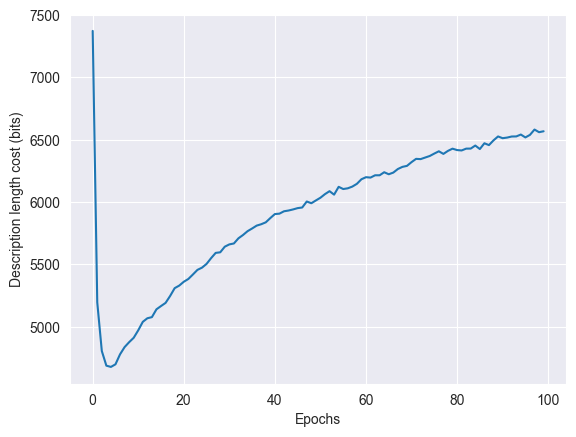

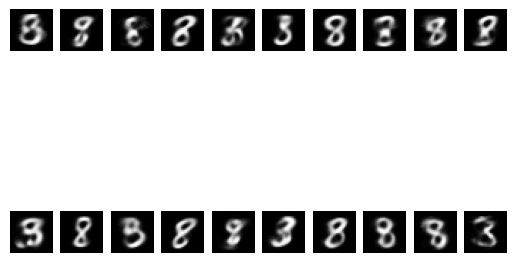

[[2.61052036e-05 3.92654874e-04 5.80606738e-04 ... 8.61213612e-05
  1.70004434e-05 2.60794826e-05]
 [8.88473365e-04 2.83476866e-04 6.62579222e-05 ... 7.49068058e-05
  1.12470261e-05 5.60503683e-06]
 [2.52513374e-04 5.31687395e-05 6.20123567e-04 ... 4.13939793e-05
  1.34100084e-05 2.82518971e-05]
 ...
 [2.25879711e-03 8.37311628e-05 3.21252216e-04 ... 1.99508810e-04
  4.60861309e-04 3.41142572e-04]
 [2.31799328e-04 6.67960449e-04 2.07024459e-03 ... 2.23414404e-04
  2.51679701e-05 2.32961719e-05]
 [2.55914460e-03 3.74240097e-03 2.86287127e-06 ... 1.77102455e-04
  8.25871899e-06 3.68083009e-07]]


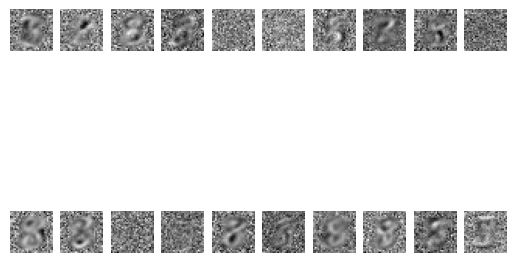

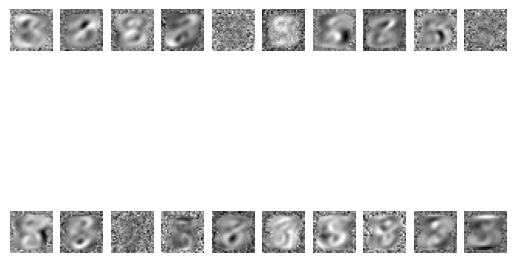

In [109]:
# for 3 and 8 
# Create a network and train it on threes and zeros
numtop = 10 # number of top layer units
numhid = 20 # number of hidden layer units
batchsize = 40
learnrate = 0.001
numepochs = 100
hnet = Helmholtz_Network([784,numhid,numtop],batchsize,learnrate)
train_zeros = train_labels == 0
train_threes = train_labels == 3
train_eights = train_labels == 8


# train on eights and threes
costs = hnet.wake_sleep_train(train_images[:,train_eights+train_threes],numepochs,
                              report_rate=2,wake_update=True,sleep_update=True)

# Plot the description length cost over epochs (if working well, should go down at first, then come up a bit)
plt.plot(costs)
plt.xlabel("Epochs")
plt.ylabel("Description length cost (bits)")
plt.show()

# Generate some images to see what the model's generative component has learned
dreams = hnet.dream(number=20)
print("dreams")
print(dreams)


# Examine the recognition weights to see what they look like
print("recognition weights")
hnet.show_rec_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_rec_weights(1,number=numhid) # for the hidden layer

print("generative weights")
# Examine some of the lowest level generative weights to see what they look like
hnet.show_gen_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_gen_weights(1,number=numhid) # for the hidden layer

Training starting...
...completed  2  epochs of training. Current avg cost is:  27406.25 bits.
...completed  4  epochs of training. Current avg cost is:  30410.85 bits.
...completed  6  epochs of training. Current avg cost is:  32378.88 bits.
...completed  8  epochs of training. Current avg cost is:  33583.27 bits.
...completed  10  epochs of training. Current avg cost is:  34460.06 bits.
...completed  12  epochs of training. Current avg cost is:  34969.98 bits.
...completed  14  epochs of training. Current avg cost is:  35384.29 bits.
...completed  16  epochs of training. Current avg cost is:  35762.64 bits.
...completed  18  epochs of training. Current avg cost is:  36066.54 bits.
...completed  20  epochs of training. Current avg cost is:  36236.16 bits.
...completed  22  epochs of training. Current avg cost is:  36529.37 bits.
...completed  24  epochs of training. Current avg cost is:  36776.95 bits.
...completed  26  epochs of training. Current avg cost is:  36949.41 bits.
...compl

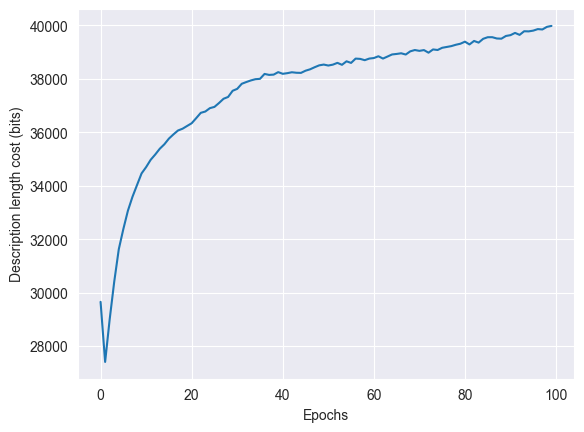

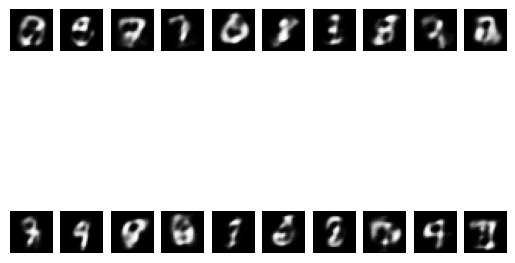

dreams
[[3.13563138e-06 3.01734938e-07 4.14290354e-04 ... 8.12087868e-05
  5.42552198e-05 2.53011774e-06]
 [4.80408367e-07 3.14097721e-06 8.30149212e-05 ... 5.04845545e-05
  1.24821933e-05 4.79960919e-06]
 [1.98585345e-05 1.04955721e-07 6.20967504e-05 ... 5.67296361e-05
  2.52913641e-05 4.86661133e-07]
 ...
 [1.61821789e-06 4.37521518e-08 1.55851084e-03 ... 3.82318401e-04
  4.66856965e-05 4.04209084e-05]
 [3.93760078e-05 1.53152888e-06 1.94259152e-04 ... 4.76504420e-05
  2.74476878e-04 1.41962154e-05]
 [6.18314140e-06 2.13728751e-07 8.13116455e-05 ... 1.43685806e-04
  1.05249758e-04 1.37188972e-05]]
recognition weights


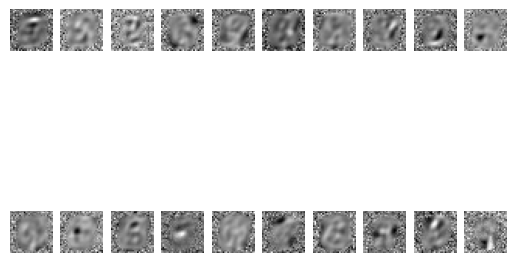

generative weights


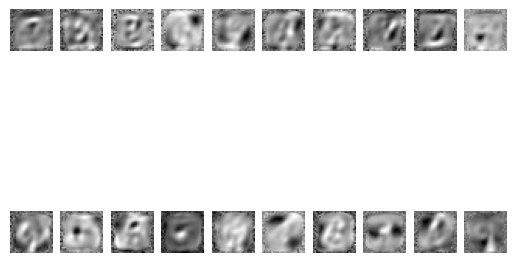

In [110]:
# for all images
# Create a network and train it on threes and zeros
numtop = 10 # number of top layer units
numhid = 20 # number of hidden layer units
batchsize = 40
learnrate = 0.001
numepochs = 100
hnet = Helmholtz_Network([784,numhid,numtop],batchsize,learnrate)
train_zeros = train_labels == 0
train_threes = train_labels == 3
train_eights = train_labels == 8


costs = hnet.wake_sleep_train(train_images,numepochs,report_rate=2,wake_update=True,sleep_update=True)

# Plot the description length cost over epochs (if working well, should go down at first, then come up a bit)
plt.plot(costs)
plt.xlabel("Epochs")
plt.ylabel("Description length cost (bits)")
plt.show()

# Generate some images to see what the model's generative component has learned
dreams = hnet.dream(number=20)
print("dreams")
print(dreams)


# Examine the recognition weights to see what they look like
print("recognition weights")
hnet.show_rec_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_rec_weights(1,number=numhid) # for the hidden layer

print("generative weights")
# Examine some of the lowest level generative weights to see what they look like
hnet.show_gen_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_gen_weights(1,number=numhid) # for the hidden layer

Note to the TA: If the loss curve for all classes looks weird, it is because of the learning rate. If you were to try the same code with learnrate = 0.0001, you would get a nicer (?) loss curve where it is starts at 45k, comes down to 25k and rises back up to 30k by epoch 50.

Training starting...
...completed  2  epochs of training. Current avg cost is:  31680.11 bits.
...completed  4  epochs of training. Current avg cost is:  27791.31 bits.
...completed  6  epochs of training. Current avg cost is:  26464.07 bits.
...completed  8  epochs of training. Current avg cost is:  25852.81 bits.
...completed  10  epochs of training. Current avg cost is:  25756.6 bits.
...completed  12  epochs of training. Current avg cost is:  25831.86 bits.
...completed  14  epochs of training. Current avg cost is:  26099.98 bits.
...completed  16  epochs of training. Current avg cost is:  26343.38 bits.
...completed  18  epochs of training. Current avg cost is:  26696.42 bits.
...completed  20  epochs of training. Current avg cost is:  27003.81 bits.
...completed  22  epochs of training. Current avg cost is:  27261.91 bits.
...completed  24  epochs of training. Current avg cost is:  27564.48 bits.
...completed  26  epochs of training. Current avg cost is:  27797.2 bits.
...complet

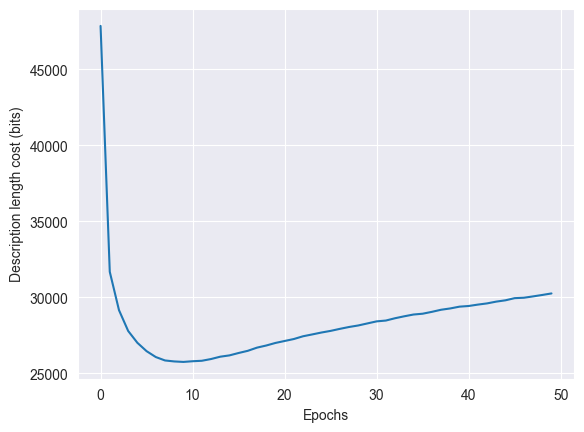

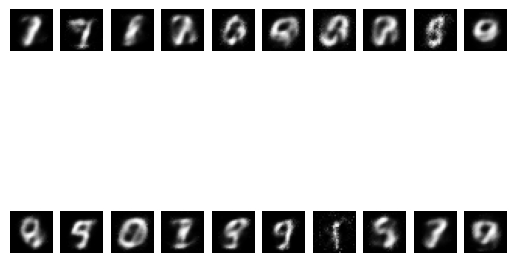

dreams
[[2.69107189e-04 1.03490265e-03 8.91964792e-05 ... 2.62343450e-04
  1.67223415e-05 3.98621260e-05]
 [1.45767757e-04 8.06332613e-03 7.48713034e-04 ... 3.49752332e-04
  1.56687603e-03 8.71528351e-06]
 [2.02033155e-03 2.01587694e-03 8.45701664e-04 ... 2.41661858e-04
  1.34339911e-05 1.53477958e-04]
 ...
 [2.95500018e-05 1.92735409e-03 1.14543374e-04 ... 1.20271625e-03
  1.62668740e-03 3.89871845e-05]
 [1.43134603e-03 1.04384518e-03 1.06191767e-03 ... 3.08910725e-04
  2.70623463e-04 3.18450393e-04]
 [5.96541882e-04 1.13064532e-05 2.67795272e-03 ... 4.48250319e-05
  1.51112554e-04 4.92240060e-04]]
recognition weights


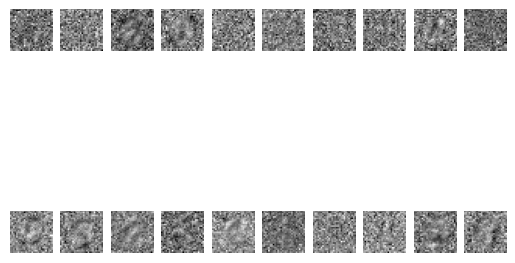

generative weights


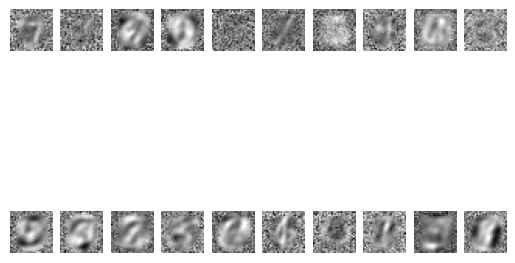

In [111]:
# for all images
# Create a network and train it on threes and zeros
numtop = 10 # number of top layer units
numhid = 20 # number of hidden layer units
batchsize = 40
learnrate = 0.0001
numepochs = 50
hnet = Helmholtz_Network([784,numhid,numtop],batchsize,learnrate)
train_zeros = train_labels == 0
train_threes = train_labels == 3
train_eights = train_labels == 8


costs = hnet.wake_sleep_train(train_images,numepochs,report_rate=2,wake_update=True,sleep_update=True)

# Plot the description length cost over epochs (if working well, should go down at first, then come up a bit)
plt.plot(costs)
plt.xlabel("Epochs")
plt.ylabel("Description length cost (bits)")
plt.show()

# Generate some images to see what the model's generative component has learned
dreams = hnet.dream(number=20)
print("dreams")
print(dreams)


# Examine the recognition weights to see what they look like
print("recognition weights")
hnet.show_rec_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_rec_weights(1,number=numhid) # for the hidden layer

print("generative weights")
# Examine some of the lowest level generative weights to see what they look like
hnet.show_gen_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_gen_weights(1,number=numhid) # for the hidden layer

100 hidden units

Training starting...
...completed  2  epochs of training. Current avg cost is:  4258.49 bits.
...completed  4  epochs of training. Current avg cost is:  3994.2 bits.
...completed  6  epochs of training. Current avg cost is:  4092.8 bits.
...completed  8  epochs of training. Current avg cost is:  4174.1 bits.
...completed  10  epochs of training. Current avg cost is:  4100.1 bits.
...completed  12  epochs of training. Current avg cost is:  4112.67 bits.
...completed  14  epochs of training. Current avg cost is:  4057.13 bits.
...completed  16  epochs of training. Current avg cost is:  4059.85 bits.
...completed  18  epochs of training. Current avg cost is:  4046.08 bits.
...completed  20  epochs of training. Current avg cost is:  4046.81 bits.
...completed  22  epochs of training. Current avg cost is:  4032.17 bits.
...completed  24  epochs of training. Current avg cost is:  4060.71 bits.
...completed  26  epochs of training. Current avg cost is:  4050.03 bits.
...completed  28  epochs 

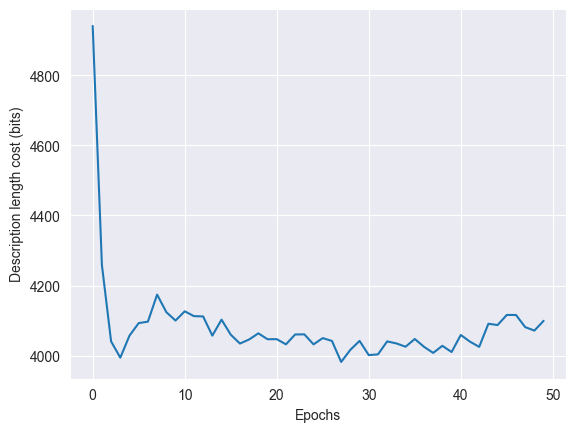

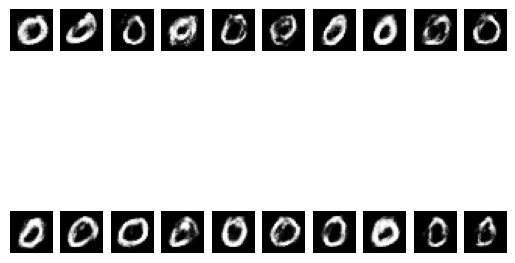

dreams
[[5.14053587e-05 1.66703284e-05 3.48907497e-07 ... 5.54293203e-03
  4.46644502e-07 1.31346484e-08]
 [4.09841084e-06 3.13645464e-09 2.90725836e-06 ... 1.31071913e-09
  6.13540458e-08 7.47537627e-09]
 [3.18311929e-05 2.96679023e-05 1.97671415e-06 ... 2.63459997e-07
  2.01795445e-05 3.48581754e-08]
 ...
 [7.25769707e-08 1.14972511e-05 4.53407655e-06 ... 9.28411213e-08
  1.14740548e-06 5.99083194e-05]
 [5.40511372e-03 1.91642019e-05 6.56590169e-06 ... 7.49826704e-08
  2.30469974e-06 2.23903766e-06]
 [1.01054990e-06 6.84502570e-04 7.33749947e-06 ... 7.55574521e-08
  5.44720053e-06 1.72238333e-07]]
recognition weights


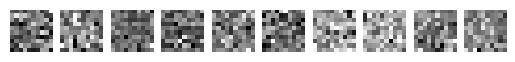

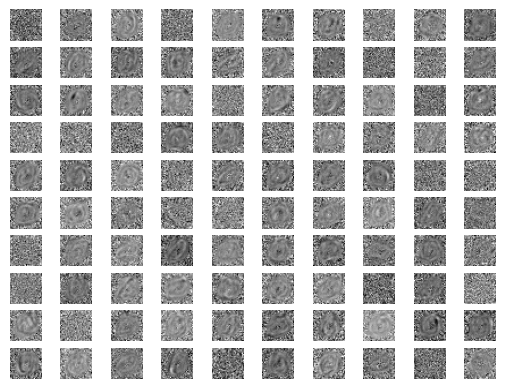

generative weights


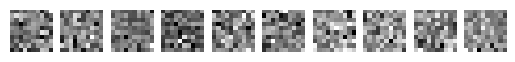

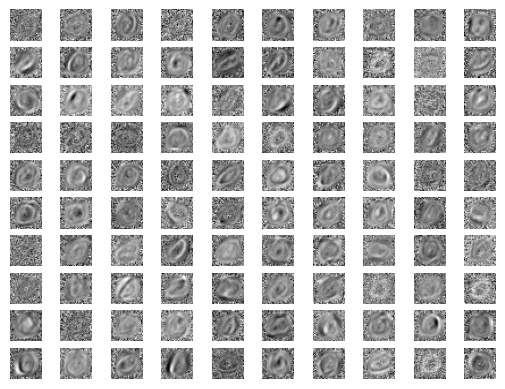

In [117]:
# for all images
# Create a network and train it on threes and zeros
numtop = 10 # number of top layer units
numhid = 100 # number of hidden layer units
batchsize = 40
learnrate = 0.01
numepochs = 50
hnet = Helmholtz_Network([784,numhid,numtop],batchsize,learnrate)
train_zeros = train_labels == 0
train_threes = train_labels == 3
train_eights = train_labels == 8

# train on just zeros
costs = hnet.wake_sleep_train(train_images[:,train_zeros],numepochs,
                              report_rate=2,wake_update=True,sleep_update=True)

# # train on eights and threes
# costs = hnet.wake_sleep_train(train_images[:,train_eights+train_threes],numepochs,
#                               report_rate=2,wake_update=True,sleep_update=True)

# train on all the 
#costs = hnet.wake_sleep_train(train_images,numepochs,report_rate=2,wake_update=True,sleep_update=True)

# Plot the description length cost over epochs (if working well, should go down at first, then come up a bit)
plt.plot(costs)
plt.xlabel("Epochs")
plt.ylabel("Description length cost (bits)")
plt.show()

# Generate some images to see what the model's generative component has learned
dreams = hnet.dream(number=20)
print("dreams")
print(dreams)


# Examine the recognition weights to see what they look like
print("recognition weights")
hnet.show_rec_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_rec_weights(1,number=numhid) # for the hidden layer

print("generative weights")
# Examine some of the lowest level generative weights to see what they look like
hnet.show_gen_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_gen_weights(1,number=numhid) # for the hidden layer

Training starting...
...completed  2  epochs of training. Current avg cost is:  8416.22 bits.
...completed  4  epochs of training. Current avg cost is:  8364.29 bits.
...completed  6  epochs of training. Current avg cost is:  8421.37 bits.
...completed  8  epochs of training. Current avg cost is:  8280.87 bits.
...completed  10  epochs of training. Current avg cost is:  8283.56 bits.
...completed  12  epochs of training. Current avg cost is:  8217.93 bits.
...completed  14  epochs of training. Current avg cost is:  8233.77 bits.
...completed  16  epochs of training. Current avg cost is:  8206.67 bits.
...completed  18  epochs of training. Current avg cost is:  8224.56 bits.
...completed  20  epochs of training. Current avg cost is:  8325.17 bits.
...completed  22  epochs of training. Current avg cost is:  8305.89 bits.
...completed  24  epochs of training. Current avg cost is:  8305.24 bits.
...completed  26  epochs of training. Current avg cost is:  8388.49 bits.
...completed  28  epo

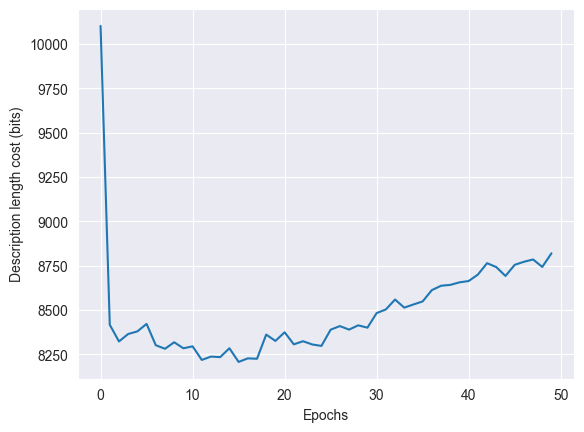

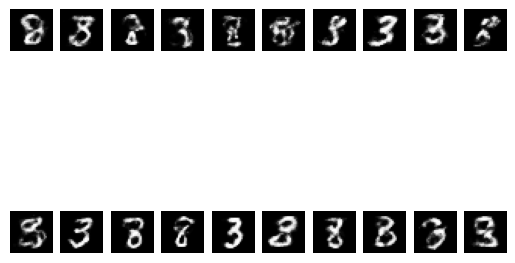

dreams
[[7.39049124e-06 4.56127880e-10 5.98120821e-09 ... 1.48090470e-04
  2.65857748e-07 2.83963960e-08]
 [3.70770118e-05 1.34401982e-06 3.45788375e-05 ... 1.52608539e-07
  5.98231502e-08 1.33859101e-08]
 [1.85938262e-04 1.84347836e-05 2.23066797e-06 ... 4.73842262e-05
  1.60868422e-05 7.84306215e-07]
 ...
 [1.32490629e-07 4.78548407e-06 8.83424661e-09 ... 4.82084840e-09
  1.20436335e-06 1.66703237e-08]
 [7.31804567e-06 3.48889319e-06 4.76614042e-03 ... 5.13834194e-08
  1.19449911e-08 1.85993204e-09]
 [2.04595309e-07 2.02037640e-04 1.26904164e-05 ... 2.77635466e-08
  2.95989895e-07 2.94446236e-10]]
recognition weights


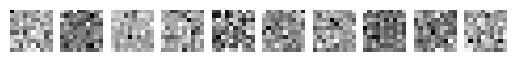

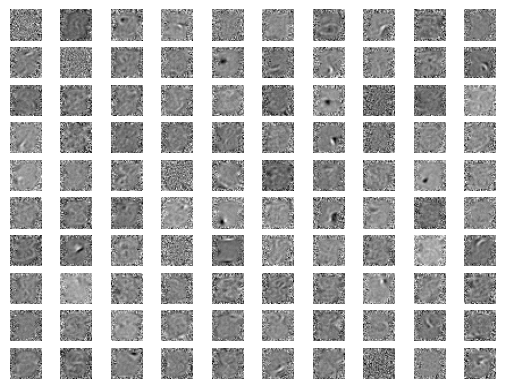

generative weights


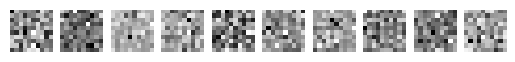

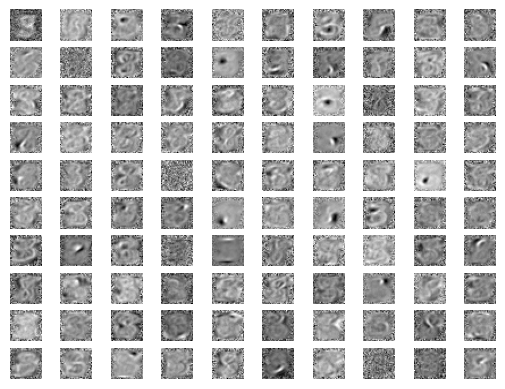

In [118]:
# for all images
# Create a network and train it on threes and zeros
numtop = 10 # number of top layer units
numhid = 100 # number of hidden layer units
batchsize = 40
learnrate = 0.01
numepochs = 50
hnet = Helmholtz_Network([784,numhid,numtop],batchsize,learnrate)
train_zeros = train_labels == 0
train_threes = train_labels == 3
train_eights = train_labels == 8


# # train on eights and threes
costs = hnet.wake_sleep_train(train_images[:,train_eights+train_threes],numepochs,
                              report_rate=2,wake_update=True,sleep_update=True)


# Plot the description length cost over epochs (if working well, should go down at first, then come up a bit)
plt.plot(costs)
plt.xlabel("Epochs")
plt.ylabel("Description length cost (bits)")
plt.show()

# Generate some images to see what the model's generative component has learned
dreams = hnet.dream(number=20)
print("dreams")
print(dreams)


# Examine the recognition weights to see what they look like
print("recognition weights")
hnet.show_rec_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_rec_weights(1,number=numhid) # for the hidden layer

print("generative weights")
# Examine some of the lowest level generative weights to see what they look like
hnet.show_gen_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_gen_weights(1,number=numhid) # for the hidden layer

Training starting...
...completed  2  epochs of training. Current avg cost is:  42989.29 bits.
...completed  4  epochs of training. Current avg cost is:  43011.37 bits.
...completed  6  epochs of training. Current avg cost is:  43111.72 bits.
...completed  8  epochs of training. Current avg cost is:  43759.55 bits.
...completed  10  epochs of training. Current avg cost is:  44721.05 bits.
...completed  12  epochs of training. Current avg cost is:  45516.61 bits.
...completed  14  epochs of training. Current avg cost is:  45893.43 bits.
...completed  16  epochs of training. Current avg cost is:  46603.74 bits.
...completed  18  epochs of training. Current avg cost is:  47366.3 bits.
...completed  20  epochs of training. Current avg cost is:  47959.44 bits.
...completed  22  epochs of training. Current avg cost is:  48540.98 bits.
...completed  24  epochs of training. Current avg cost is:  48926.03 bits.
...completed  26  epochs of training. Current avg cost is:  49385.12 bits.
...comple

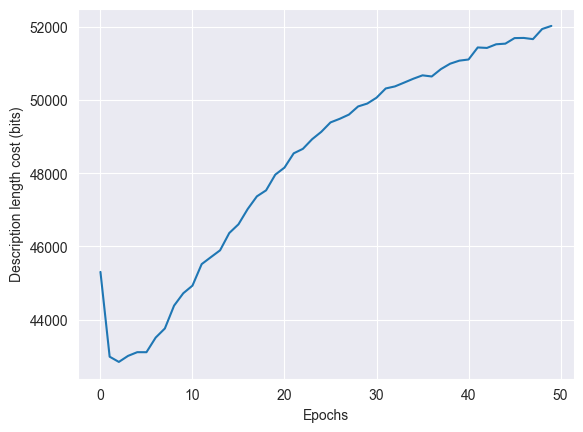

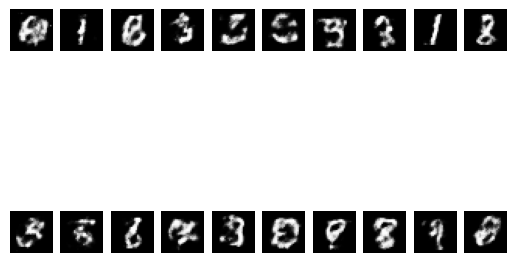

dreams
[[1.91570898e-09 6.43810231e-11 3.79797387e-07 ... 1.65989042e-08
  1.49077123e-10 5.85763068e-10]
 [7.83234278e-07 6.38744656e-10 3.02936807e-07 ... 6.09292985e-08
  6.90420864e-10 3.14950148e-11]
 [7.40155404e-06 4.18116672e-08 3.90542908e-06 ... 4.55328675e-05
  1.41412634e-10 1.90551252e-11]
 ...
 [2.85826474e-09 9.19690023e-08 8.50356383e-07 ... 1.69652346e-06
  4.35237724e-11 2.44122226e-10]
 [7.32147269e-08 1.51009903e-09 3.23741625e-09 ... 2.72776402e-09
  7.80753705e-12 1.49730138e-10]
 [2.39013803e-06 2.92407245e-09 2.90174312e-08 ... 6.18950142e-10
  4.31112624e-11 1.12787020e-10]]
recognition weights


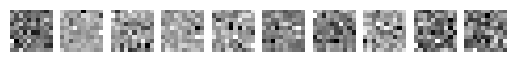

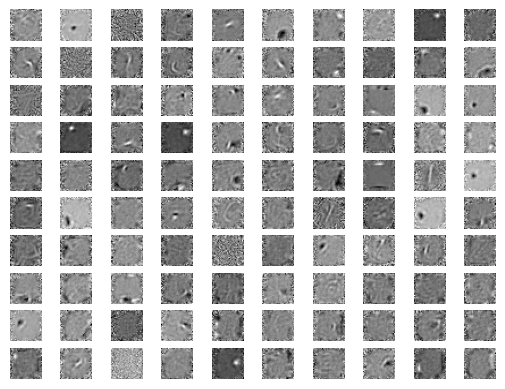

generative weights


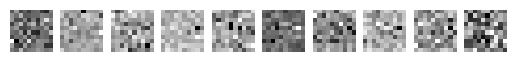

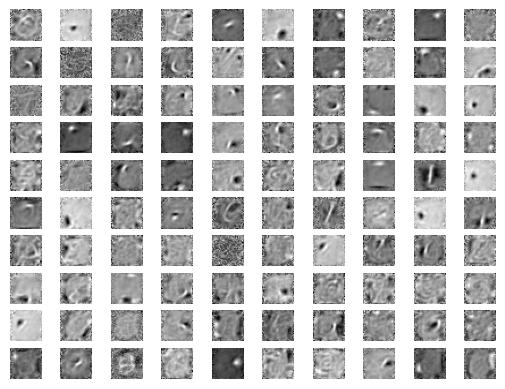

In [119]:
# for all images
# Create a network and train it on threes and zeros
numtop = 10 # number of top layer units
numhid = 100 # number of hidden layer units
batchsize = 40
learnrate = 0.01
numepochs = 50
hnet = Helmholtz_Network([784,numhid,numtop],batchsize,learnrate)
train_zeros = train_labels == 0
train_threes = train_labels == 3
train_eights = train_labels == 8


costs = hnet.wake_sleep_train(train_images,numepochs,report_rate=2,wake_update=True,sleep_update=True)

# Plot the description length cost over epochs (if working well, should go down at first, then come up a bit)
plt.plot(costs)
plt.xlabel("Epochs")
plt.ylabel("Description length cost (bits)")
plt.show()

# Generate some images to see what the model's generative component has learned
dreams = hnet.dream(number=20)
print("dreams")
print(dreams)


# Examine the recognition weights to see what they look like
print("recognition weights")
hnet.show_rec_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_rec_weights(1,number=numhid) # for the hidden layer

print("generative weights")
# Examine some of the lowest level generative weights to see what they look like
hnet.show_gen_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_gen_weights(1,number=numhid) # for the hidden layer

# Turn of wake or sleep

Training starting...
...completed  2  epochs of training. Current avg cost is:  10227.23 bits.
...completed  4  epochs of training. Current avg cost is:  10346.39 bits.
...completed  6  epochs of training. Current avg cost is:  10484.92 bits.
...completed  8  epochs of training. Current avg cost is:  10558.15 bits.
...completed  10  epochs of training. Current avg cost is:  10629.92 bits.
...completed  12  epochs of training. Current avg cost is:  10698.38 bits.
...completed  14  epochs of training. Current avg cost is:  10728.85 bits.
...completed  16  epochs of training. Current avg cost is:  10767.01 bits.
...completed  18  epochs of training. Current avg cost is:  10784.07 bits.
...completed  20  epochs of training. Current avg cost is:  10819.07 bits.
...completed  22  epochs of training. Current avg cost is:  10859.4 bits.
...completed  24  epochs of training. Current avg cost is:  10888.66 bits.
...completed  26  epochs of training. Current avg cost is:  10882.22 bits.
...comple

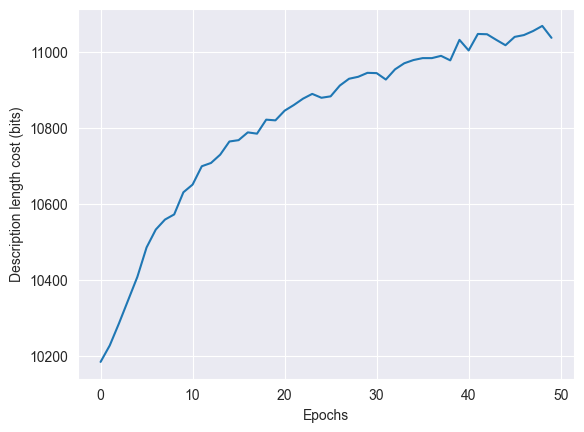

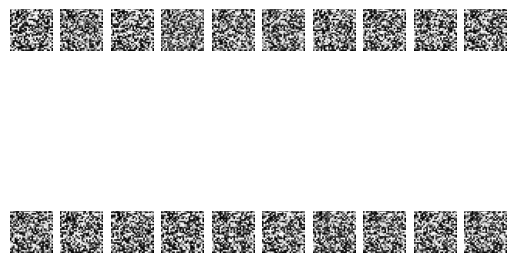

dreams
[[9.07126702e-01 2.70069739e-01 7.04452415e-01 ... 6.79782034e-01
  3.71827108e-02 5.98469051e-01]
 [5.74523825e-01 6.38831021e-01 5.90156437e-01 ... 5.06036779e-02
  9.98543411e-01 9.11804933e-01]
 [9.65982830e-01 3.34641517e-02 3.55838212e-01 ... 8.97954626e-01
  4.60341383e-02 3.31093899e-01]
 ...
 [2.01906364e-02 1.52002690e-01 8.74067904e-01 ... 8.16027074e-01
  8.11315473e-01 3.57860580e-01]
 [9.64701830e-01 8.80000313e-01 9.89592917e-01 ... 5.47884269e-02
  9.92764490e-01 9.89317734e-01]
 [2.88640623e-02 1.21392166e-01 8.07950161e-04 ... 5.23859468e-02
  2.34483813e-01 1.20884935e-02]]
recognition weights


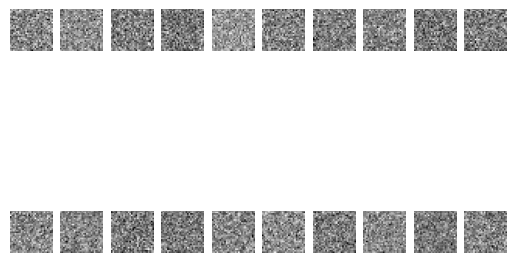

generative weights


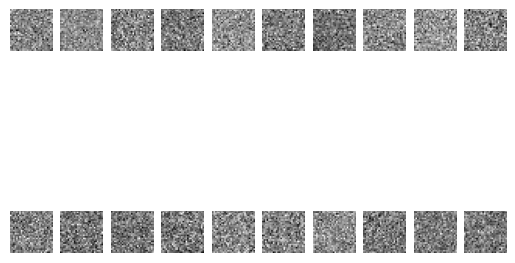

In [126]:
# for all images
# Create a network and train it on threes and zeros
numtop = 10 # number of top layer units
numhid = 20 # number of hidden layer units
batchsize = 40
learnrate = 0.001
numepochs = 50
hnet = Helmholtz_Network([784,numhid,numtop],batchsize,learnrate)
train_zeros = train_labels == 0
train_threes = train_labels == 3
train_eights = train_labels == 8


# train on just zeros
costs = hnet.wake_sleep_train(train_images[:,train_zeros],numepochs,
                              report_rate=2,wake_update=False,sleep_update=True)

# Plot the description length cost over epochs (if working well, should go down at first, then come up a bit)
plt.plot(costs)
plt.xlabel("Epochs")
plt.ylabel("Description length cost (bits)")
plt.show()

# Generate some images to see what the model's generative component has learned
dreams = hnet.dream(number=20)
print("dreams")
print(dreams)


# Examine the recognition weights to see what they look like
print("recognition weights")
hnet.show_rec_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_rec_weights(1,number=numhid) # for the hidden layer

print("generative weights")
# Examine some of the lowest level generative weights to see what they look like
hnet.show_gen_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_gen_weights(1,number=numhid) # for the hidden layer

Training starting...
...completed  2  epochs of training. Current avg cost is:  2669.55 bits.
...completed  4  epochs of training. Current avg cost is:  2427.82 bits.
...completed  6  epochs of training. Current avg cost is:  2329.38 bits.
...completed  8  epochs of training. Current avg cost is:  2291.77 bits.
...completed  10  epochs of training. Current avg cost is:  2271.74 bits.
...completed  12  epochs of training. Current avg cost is:  2254.32 bits.
...completed  14  epochs of training. Current avg cost is:  2260.65 bits.
...completed  16  epochs of training. Current avg cost is:  2261.64 bits.
...completed  18  epochs of training. Current avg cost is:  2262.03 bits.
...completed  20  epochs of training. Current avg cost is:  2277.06 bits.
...completed  22  epochs of training. Current avg cost is:  2293.25 bits.
...completed  24  epochs of training. Current avg cost is:  2281.65 bits.
...completed  26  epochs of training. Current avg cost is:  2287.0 bits.
...completed  28  epoc

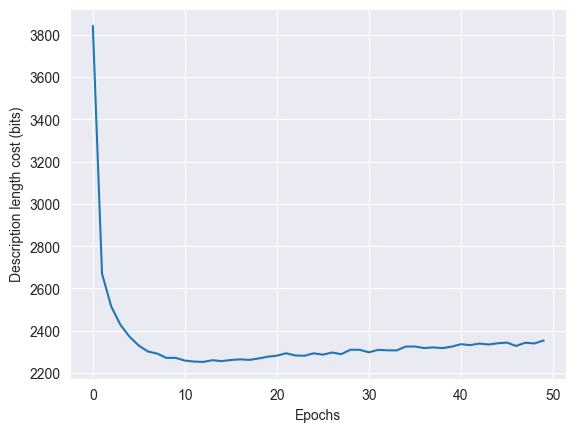

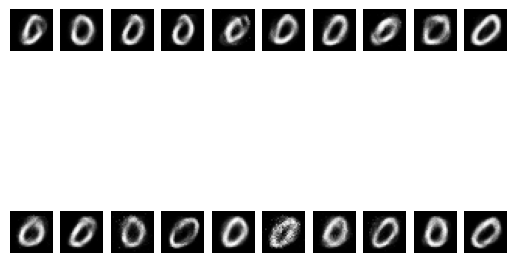

dreams
[[8.90783668e-04 1.03577449e-05 5.96794356e-05 ... 3.78498547e-05
  2.43415146e-04 1.04484824e-04]
 [5.44264585e-05 6.43981397e-04 1.63000226e-04 ... 1.82816025e-04
  7.98697804e-05 1.12888810e-04]
 [3.97431228e-04 2.89800406e-04 1.95268242e-04 ... 8.80683046e-04
  1.96051762e-03 6.13316491e-04]
 ...
 [5.21406972e-04 1.47162706e-05 1.02445547e-06 ... 7.89981220e-04
  1.39302016e-02 8.17238228e-05]
 [5.73805357e-04 5.27129711e-05 8.32098365e-05 ... 1.90770698e-04
  1.40331392e-03 1.35891925e-04]
 [2.40927169e-04 5.01392717e-04 2.91815934e-04 ... 9.83168935e-05
  8.09251592e-04 1.20134542e-04]]
recognition weights


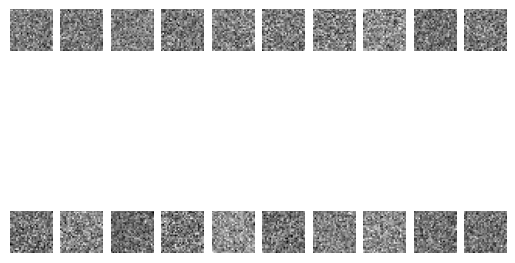

generative weights


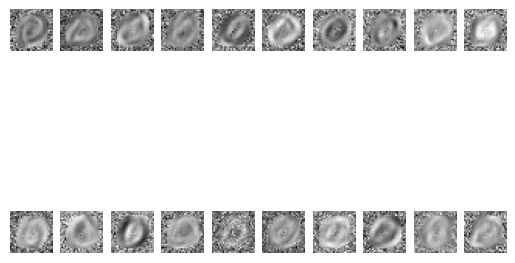

In [127]:
# sleep off
# Create a network and train it on threes and zeros
numtop = 10 # number of top layer units
numhid = 20 # number of hidden layer units
batchsize = 40
learnrate = 0.001
numepochs = 50
hnet = Helmholtz_Network([784,numhid,numtop],batchsize,learnrate)
train_zeros = train_labels == 0
train_threes = train_labels == 3
train_eights = train_labels == 8


# train on just zeros
costs = hnet.wake_sleep_train(train_images[:,train_zeros],numepochs,
                              report_rate=2,wake_update=True,sleep_update=False)

# Plot the description length cost over epochs (if working well, should go down at first, then come up a bit)
plt.plot(costs)
plt.xlabel("Epochs")
plt.ylabel("Description length cost (bits)")
plt.show()

# Generate some images to see what the model's generative component has learned
dreams = hnet.dream(number=20)
print("dreams")
print(dreams)


# Examine the recognition weights to see what they look like
print("recognition weights")
hnet.show_rec_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_rec_weights(1,number=numhid) # for the hidden layer

print("generative weights")
# Examine some of the lowest level generative weights to see what they look like
hnet.show_gen_weights(2,image_size=(int(np.floor(numhid/10)),10),number=numtop) # for the top layer
hnet.show_gen_weights(1,number=numhid) # for the hidden layer